In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1. Setting up data and spliting into train/valid/test**

In [ ]:
#transforming high resolution data to tensors and is labeled
#SRCNN generated and HR images
dataset1 = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360/APS360 Project/Code_Data/Classifier Data/SRCNN', transform=transforms.ToTensor())
dataset2 = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360/APS360 Project/Code_Data/Classifier Data/SRGAN', transform=transforms.ToTensor())

In [ ]:
#split SRCNN into train (70%) and test (30%)
split = int(0.7*len(dataset1))
lens = (split, len(dataset1) - split)
train_set1, test_set1 = torch.utils.data.random_split(dataset1,lens)

# Split SRCNN test (30%) into test and val data (15% each)
split = int(0.5*len(test_set1))
lens = (split, len(test_set1) - split)
test_set1, val_set1 = torch.utils.data.random_split(test_set1,lens)

#split GAN into train (70%) and test (30%)
split = int(0.7*len(dataset2))
lens = (split, len(dataset2) - split)
train_set2, test_set2 = torch.utils.data.random_split(dataset2,lens)
print(len(train_set2)+len(train_set1))
# Split GAN test (30%) into test and val data (15% each)
split = int(0.5*len(test_set2))
lens = (split, len(test_set2) - split)
test_set2, val_set2 = torch.utils.data.random_split(test_set2,lens)

train_set = torch.utils.data.ConcatDataset([train_set1,train_set2])
val_set = torch.utils.data.ConcatDataset([val_set1,val_set2])
test_set = torch.utils.data.ConcatDataset([test_set1,test_set2])


1260


In [ ]:
len(train_set)
#each datapoint is (3x224, 0 or 1)

1260

# **2. Build Classifier (based on Lab 2) and develop train code**

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(15125, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 15125)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        # labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [ ]:
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def train_net(net, train_set,val_set, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on HR vs LR photos
    target_classes = ['Generated', 'HR']
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    
    ##---remove eventually---
    # my_subset = torch.utils.data.Subset(train_set, [1800,2200])
    train_loader = torch.utils.data.DataLoader(train_set, shuffle=False)
    ##---remove eventually---

    # train_loader = torch.utils.data.DataLoader(train_set, 
                                              #  batch_size=batch_size, 
                                              #  shuffle=False)
    
    val_loader = torch.utils.data.DataLoader(val_set, 
                                               batch_size=batch_size, 
                                               shuffle=False)
    
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.

    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            # print(labels,1)
            # print(inputs)
            # labels = normalize_label(labels) # Convert labels to 0/1
            # print(labels,2)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
len(train_set)

420

# **3. Train the model and plot results for tuning**


In [ ]:
############### Iteration 1: Batch size = 10, lr = 0.01, epoch = 30 ###############
model = SmallNet()
train_net(model, train_set,val_set, batch_size=10)

Epoch 1: Train err: 0.4928571428571429, Train loss: 0.7392960082208789 |Validation err: 0.5, Validation loss: 0.6992209090126885
Epoch 2: Train err: 0.5023809523809524, Train loss: 0.6992393197757857 |Validation err: 0.5, Validation loss: 0.6933520370059543
Epoch 3: Train err: 0.4714285714285714, Train loss: 0.6989832825603939 |Validation err: 0.5, Validation loss: 0.6933773159980774
Epoch 4: Train err: 0.48095238095238096, Train loss: 0.6933371570848283 |Validation err: 0.5, Validation loss: 0.6984594133165147
Epoch 5: Train err: 0.5404761904761904, Train loss: 0.7036625484625498 |Validation err: 0.5, Validation loss: 0.6966501341925727
Epoch 6: Train err: 0.530952380952381, Train loss: 0.7031469126542409 |Validation err: 0.5, Validation loss: 0.6938400136099921
Epoch 7: Train err: 0.4880952380952381, Train loss: 0.6998157552310399 |Validation err: 0.5, Validation loss: 0.6956704590055678
Epoch 8: Train err: 0.5571428571428572, Train loss: 0.7010997187523614 |Validation err: 0.5, Vali

----------------------- SMALL, BS = 10, LR = 0.01, EPOCHS = 30 -----------------------



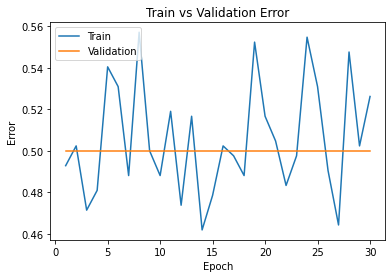

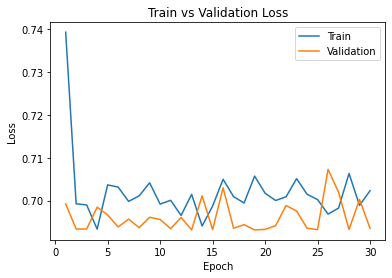

In [ ]:
model_path = get_model_name("small", batch_size=10, learning_rate=0.01, epoch=29)
print("----------------------- SMALL, BS = 10, LR = 0.01, EPOCHS = 30 -----------------------\n")
plot_training_curve(model_path)

In [ ]:
############### Iteration 2: Batch size = 30, lr = 0.001, epoch = 20 ###############
model = SmallNet()
train_net(model, train_set,val_set, batch_size=30,learning_rate=0.001, num_epochs = 20)

Epoch 1: Train err: 0.3761904761904762, Train loss: 0.6962120602528254 |Validation err: 0.3, Validation loss: 0.6676070888837179
Epoch 2: Train err: 0.29285714285714287, Train loss: 0.6219428967906251 |Validation err: 0.25555555555555554, Validation loss: 0.596464216709137
Epoch 3: Train err: 0.2785714285714286, Train loss: 0.573340581780732 |Validation err: 0.3, Validation loss: 0.596002201239268
Epoch 4: Train err: 0.21904761904761905, Train loss: 0.5429043514931122 |Validation err: 0.28888888888888886, Validation loss: 0.6210294564565023
Epoch 5: Train err: 0.22857142857142856, Train loss: 0.5190266037544244 |Validation err: 0.2777777777777778, Validation loss: 0.5498772064844767
Epoch 6: Train err: 0.23809523809523808, Train loss: 0.5059819807872329 |Validation err: 0.28888888888888886, Validation loss: 0.5897202889124552
Epoch 7: Train err: 0.2119047619047619, Train loss: 0.4882789246022488 |Validation err: 0.24444444444444444, Validation loss: 0.5815578897794088
Epoch 8: Train er

----------------------- SMALL, BS = 30, LR = 0.001, EPOCHS = 20 -----------------------



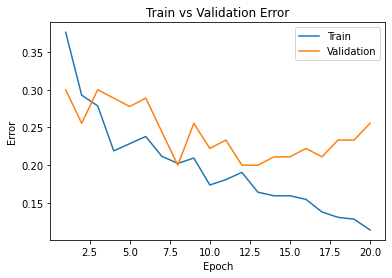

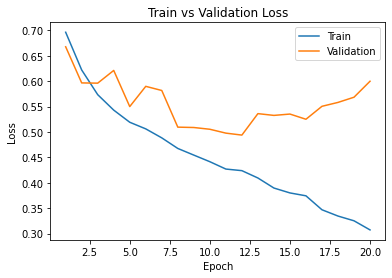

In [ ]:
model_path = get_model_name("small", batch_size=30, learning_rate=0.001, epoch=19)
print("----------------------- SMALL, BS = 30, LR = 0.001, EPOCHS = 20 -----------------------\n")
plot_training_curve(model_path)

In [ ]:
############### Iteration 3: Batch size = 35, lr = 0.0008, epoch = 10 ###############
model = SmallNet()
train_net(model, train_set,val_set, batch_size=35,learning_rate= 0.0008, num_epochs = 10)

Epoch 1: Train err: 0.36904761904761907, Train loss: 0.6993328994760911 |Validation err: 0.3333333333333333, Validation loss: 0.6745126644770304
Epoch 2: Train err: 0.31666666666666665, Train loss: 0.6549947277332345 |Validation err: 0.2777777777777778, Validation loss: 0.6380288402239481
Epoch 3: Train err: 0.2904761904761905, Train loss: 0.5982975782427404 |Validation err: 0.2777777777777778, Validation loss: 0.6134037574132284
Epoch 4: Train err: 0.24761904761904763, Train loss: 0.57181423648844 |Validation err: 0.28888888888888886, Validation loss: 0.5992753108342489
Epoch 5: Train err: 0.24047619047619048, Train loss: 0.5402976526411727 |Validation err: 0.26666666666666666, Validation loss: 0.5609957575798035
Epoch 6: Train err: 0.24285714285714285, Train loss: 0.5280320840262686 |Validation err: 0.2777777777777778, Validation loss: 0.5745581785837809
Epoch 7: Train err: 0.22142857142857142, Train loss: 0.5104005886418669 |Validation err: 0.26666666666666666, Validation loss: 0.55

----------------------- SMALL, BS = 35, LR = 0.0008, EPOCHS = 10 -----------------------



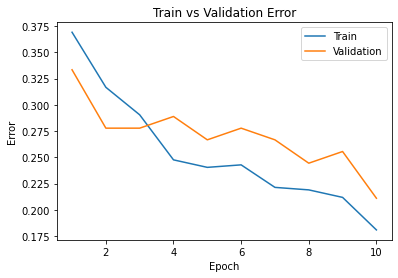

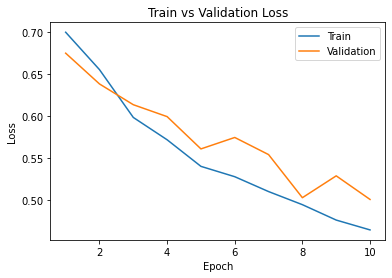

In [ ]:
model_path = get_model_name("small", batch_size=35, learning_rate=0.0008, epoch=9)
print("----------------------- SMALL, BS = 35, LR = 0.0008, EPOCHS = 10 -----------------------\n")
plot_training_curve(model_path)

In [ ]:
############### Iteration 4: Batch size = 30, lr = 0.001, epoch = 10 ###############
model = SmallNet()
train_net(model, train_set,val_set, batch_size=30,learning_rate=0.001, num_epochs = 10)

Epoch 1: Train err: 0.5015873015873016, Train loss: 0.698753819549604 |Validation err: 0.5037037037037037, Validation loss: 0.6935798459582858
Epoch 2: Train err: 0.4857142857142857, Train loss: 0.6912463414054069 |Validation err: 0.4925925925925926, Validation loss: 0.691465311580234
Epoch 3: Train err: 0.46746031746031746, Train loss: 0.691289815472232 |Validation err: 0.4777777777777778, Validation loss: 0.6900530921088325
Epoch 4: Train err: 0.45396825396825397, Train loss: 0.6899808196321366 |Validation err: 0.5111111111111111, Validation loss: 0.6963025662634108
Epoch 5: Train err: 0.4174603174603175, Train loss: 0.6852652821512449 |Validation err: 0.46296296296296297, Validation loss: 0.6898469660017226
Epoch 6: Train err: 0.41825396825396827, Train loss: 0.676128506076537 |Validation err: 0.34444444444444444, Validation loss: 0.6544585492875841
Epoch 7: Train err: 0.25793650793650796, Train loss: 0.5647686612589048 |Validation err: 0.337037037037037, Validation loss: 0.56263897

----------------------- SMALL, BS = 30, LR = 0.001, EPOCHS = 10 -----------------------



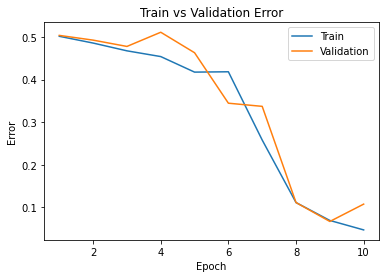

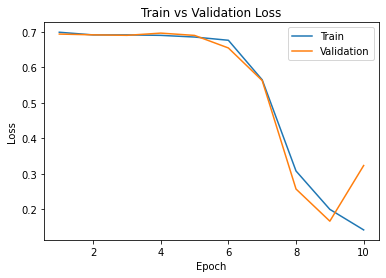

In [ ]:
model_path = get_model_name("small", batch_size=30, learning_rate=0.001, epoch=9)
print("----------------------- SMALL, BS = 30, LR = 0.001, EPOCHS = 10 -----------------------\n")
plot_training_curve(model_path)

# **4. Test data and evaluate**

In [ ]:
####SRCNN test#####
test_loader = torch.utils.data.DataLoader(test_set1, batch_size=30, shuffle=True)
evaluate(model,test_loader,nn.BCEWithLogitsLoss())

(0.28888888888888886, 0.5452505846818289)

In [ ]:
#####SRGAN test#####
test_loader = torch.utils.data.DataLoader(test_set2, batch_size=30, shuffle=True)
evaluate(model,test_loader,nn.BCEWithLogitsLoss())

(0.1, 0.2524277667204539)